## Clustering with DMD

[Based off of Koopman Operator Framework for Time Series Modeling and Analysis](https://link.springer.com/article/10.1007/s00332-017-9441-y) by Amit Surana

In [1]:
from pydmd import DMD
from pydmd.plotter import plot_summary
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import linprog
from scipy.spatial.distance import pdist, squareform


from sklearn.manifold import MDS
from sklearn.cluster import k_means
from sklearn.cluster import k_means
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
import time
import re
import inspect
import pickle

plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [2]:
def get_lambda_source(lambda_func):
    try:
        source_lines = inspect.getsource(lambda_func)
        return source_lines.strip()
    except OSError:
        return None

In [74]:
rng = np.random.default_rng()

f1  = lambda x: x/5 * rng.uniform(0.8, 1.2)
f2  = lambda x: x**0.4 * rng.uniform(0.8, 1.2)
f3  = lambda x: np.sqrt(x + rng.uniform(0, 1))
f4  = lambda x: np.log(x + 1 + rng.uniform(0, 2))
f5  = lambda x: np.exp(-rng.uniform(0.005, 0.02) * x)
f6  = lambda x: np.exp(-((x - rng.uniform(40, 60))/rng.uniform(8, 15))**2)
f7  = lambda x: np.sin(rng.uniform(0.05, 0.15) * x)
f8  = lambda x: np.cos(rng.uniform(0.05, 0.15) * x)
f9  = lambda x: np.sin(rng.uniform(0.08, 0.12) * x) * np.exp(-rng.uniform(0.005, 0.02) * x)
f10 = lambda x: x * np.exp(-rng.uniform(0.03, 0.07) * x)

f11 = lambda x: np.log(x + 1 + rng.uniform(0, 1)) * np.sin(rng.uniform(0.15, 0.25) * x)
f12 = lambda x: np.tanh((x - rng.uniform(45, 55)) / rng.uniform(8, 15))
f13 = lambda x: np.sin(x / rng.uniform(4, 6))**2
f14 = lambda x: 1 / (1 + x + rng.uniform(0, 1))
f15 = lambda x: np.exp(-np.sqrt(x + rng.uniform(0, 2)))
f16 = lambda x: np.sin(x / rng.uniform(2, 5)) + rng.uniform(0.005, 0.02) * x
f17 = lambda x: np.cos(x / rng.uniform(3, 5)) * np.exp(-rng.uniform(0.005, 0.02) * x)
f18 = lambda x: np.sin(rng.uniform(0.15, 0.25) * x) * np.sin(rng.uniform(0.03, 0.07) * x)
f19 = lambda x: (
    np.exp(-((x - rng.uniform(25, 35)) / rng.uniform(4, 6))**2) +
    np.exp(-((x - rng.uniform(65, 75)) / rng.uniform(4, 6))**2)
)
f20 = lambda x: np.sinh(rng.uniform(0.008, 0.015) * x)

random_functions = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10,
             f11, f12, f13, f14, f15, f16, f17, f18, f19, f20]

random_functions = {f'f{i+1}' : f for i,f in enumerate(random_functions)}

In [4]:
def create_time_series(domain,random_functions,fs,plot=False):

    x_values = []
    for f in fs:
        x_values.append(random_functions[f](domain))
    
    X = np.vstack(x_values).T

    return X

In [5]:
def dmd_by_hand(X_full,rank):
    m, n = X_full.shape

    if rank < 0 or rank > m:
        raise ValueError(f'Given rank is {rank} yet data given has dimension {m}')
    
    X = X_full[:,:-1]
    Y = X_full[:,1:]
    
    # SVD of X
    U, s, Vh = np.linalg.svd(X, full_matrices=False)
    
    # r rank of svd of X
    U_r = U[:,:rank]
    s_r = s[:rank]
    Vh_r = Vh[:rank,:]
    
    # Calculate A_tilde
    U_r_star = U_r.conj().T
    V_r = Vh_r.conj().T
    S_r_inv = np.diag(1.0 / s_r)
    
    A_tilde = U_r_star @ Y @ V_r @ S_r_inv
    
    # Eigendecomposition of A_tilde
    eigs, W = np.linalg.eig(A_tilde)
    
    # Koopman Modes & amplitudes
    modes = Y @ V_r @ S_r_inv @ W
    b, _, _, _ = np.linalg.lstsq(modes,X[:,0])

    return eigs, modes, b

### Create Dataset

In [84]:
n = 1000
m = 4
num_cats = 3
num_samples = 20
delay_embeddings = 3
num_observables = m * (delay_embeddings + 1)
n += delay_embeddings
num_segments = 5

if np.mod(n-delay_embeddings,num_segments) != 0:
    raise ValueError(f'Number of segments {num_segments} must divide given data size {n-delay_embeddings}')

segment_length = int(n/num_segments)

cats = [f'c{i}' for i in range(num_cats)]
domain = np.linspace(0,100,n)

data = []
models = []
all_eigs = []
all_modes = []
all_amps = []
funcs = {cat : None for cat in cats}

total_dmd_calculations = num_cats * num_samples * num_segments
print(f'Generating {total_dmd_calculations} DMD eigs/modes each with dimensionality {num_observables}')

for cat in cats:

    fs = np.random.choice(list(random_functions.keys()),size=m,replace=True)
    
    funcs[cat] = fs # [get_lambda_source(random_functions[f]) for f in fs]
    
    for i in tqdm(range(num_samples),desc=f'Category {cat} Data Processing & DMD',unit='sample'):
    
        X = create_time_series(domain,
                               random_functions,
                               fs,
                               plot=False)

        if delay_embeddings > 0:
            X = np.hstack([X[i:n-delay_embeddings+i,:] for i in range(delay_embeddings+1)])

        
        # dmd = DMD(svd_rank=num_observables)
        # dmd.fit(X.T);
        # data.append(X)
        # models.append(dmd)

        # DMD by Hand

        for sp in range(num_segments):
            start_ind = sp * segment_length
            end_ind = (sp + 1) * segment_length
            X_split = X[start_ind:end_ind,:]
            
            eigs, modes, b = dmd_by_hand(X_split.T, rank=num_observables)
            all_eigs.append(eigs)
            all_modes.append(modes)
            all_amps.append(b)

if len(all_eigs) != total_dmd_calculations:
    raise ValueError(f'Incorrect Number of DMD Run: expected {total_dmd_calculations}, but ran {len(all_eigs)}')

if all_eigs[0].shape[0] != num_observables:
    raise ValueError(f'Incorrect Observables Count: expected {num_observables}, but got {all_eigs[0].shape[0]}')

Generating 300 DMD eigs/modes each with dimensionality 16


Category c2 Data Processing & DMD: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 215.07sample/s]


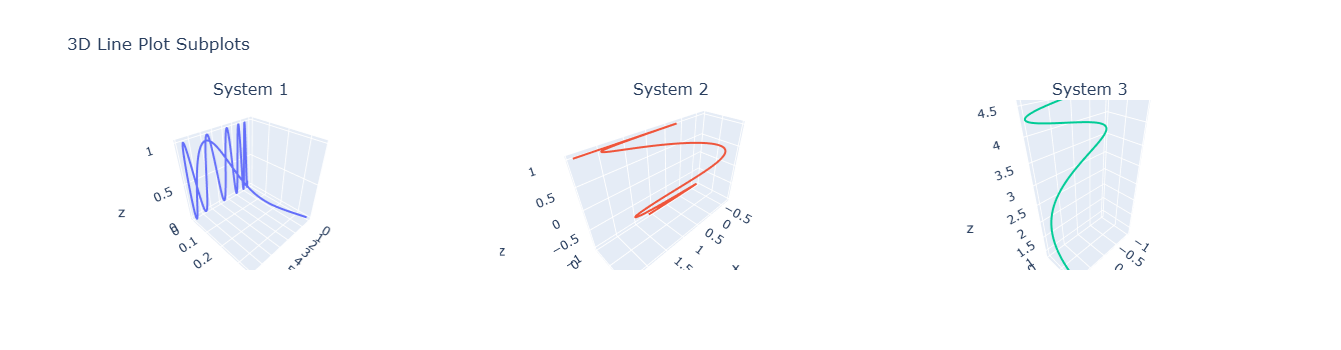

In [85]:
fig = make_subplots(
    rows=1, cols=num_cats,
    specs=[[{'type': 'scene'}]*num_cats],
    subplot_titles=[f'System {i+1}' for i in range(len(funcs))]
)

for i, (category, fs) in enumerate(funcs.items()):

    x_values = []
    for f in fs:
        x_values.append(random_functions[f](domain))

    trace = go.Scatter3d(
        x=x_values[0], y=x_values[1], z=x_values[2],
        mode='lines',
        line=dict(width=4),
        name=f"Spiral {i+1}"
    )

    # Add trace to the correct subplot
    fig.add_trace(trace, row=1, col=i+1)

# Update layout
fig.update_layout(
    title="3D Line Plot Subplots",
    height=350,
    width=1100,
    showlegend=False
)

fig.show()

In [86]:
real_eigs = []
imag_eigs = []
full_modes = []

for i in tqdm(range(len(all_eigs))):
    eigs = all_eigs[i]
    modes = all_modes[i]
    
    real_eigs.append(eigs.real)
    imag_eigs.append(eigs.imag)

    norm_modes = [np.linalg.norm(modes[:,k]) / sum(np.linalg.norm(modes,axis=0)) for k in range(num_observables)]
    
    full_modes.append(norm_modes)

real_eigs = np.array(real_eigs)
imag_eigs = np.array(imag_eigs)
full_modes = np.array(full_modes)
target = np.array([i for i in range(num_cats) for _ in range(num_segments) for _ in range(num_samples)])[:,np.newaxis]
sample = np.array([j for _ in range(num_cats) for j in range(num_samples) for _ in range(num_segments)])[:,np.newaxis]
segment = np.array([k for _ in range(num_cats) for _ in range(num_samples) for k in range(num_segments)])[:,np.newaxis]

columns = [f'eig_{i}' for i in range(num_observables)] + [f'real_{i}' for i in range(num_observables)] + [f'imag_{i}' for i in range(num_observables)] + [f'norm_mode_{i}' for i in range(num_observables)] + ['target','sample','segment']
df = pd.DataFrame(data=np.hstack([np.array(all_eigs),real_eigs,imag_eigs,full_modes,target,sample,segment]),columns=columns)

for col in df.columns:
    if 'eig' not in col:
        df[col] = df[col].astype(float)
df['target'] = df['target'].astype(int)
df['sample'] = df['sample'].astype(int)
df['segment'] = df['segment'].astype(int)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1155.58it/s]


### Clustering

In [87]:
def compute_wasserstein_metric(loc1,loc2,df,num_observables):
    # --- Step 1: Sample Inputs ---
    n = num_observables
    n_bar = num_observables

    eig_columns = [col for col in df.columns if 'eig' in col]
    norm_mode_columns = [col for col in df.columns if 'norm_mode' in col]
    
    # Random positions (e.g. eigenvalues or vectors)
    lambda_vals = df.loc[loc1,eig_columns].values[:,np.newaxis]       # shape (n, d)
    lambda_bar_vals = df.loc[loc2,eig_columns].values[:,np.newaxis]   # shape (n_bar, d)
    
    # Mass vectors (must sum to 1)
    m_1 = df.loc[loc1,norm_mode_columns].values.real          # size n
    m_2 = df.loc[loc2,norm_mode_columns].values.real      # size n_bar
    
    assert np.isclose(np.sum(m_1), 1.0)
    assert np.isclose(np.sum(m_2), 1.0)
    
    # --- Step 2: Compute cost matrix C (shape n x n_bar) ---
    C = np.linalg.norm(lambda_vals[:, None, :] - lambda_bar_vals[None, :, :], axis=2) ** 2
    # Flatten to 1D for linprog
    c = C.flatten()  # size (n * n_bar,)
    
    # --- Step 3: Equality Constraints ---
    
    # Total number of variables
    N = n * n_bar
    
    # 1. Row sum constraints: each row i must sum to m[i]
    A_eq_rows = np.zeros((n, N))
    for i in range(n):
        for j in range(n_bar):
            A_eq_rows[i, i * n_bar + j] = 1
    b_eq_rows = m_1
    
    # 2. Column sum constraints: each column j must sum to m_bar[j]
    A_eq_cols = np.zeros((n_bar, N))
    for j in range(n_bar):
        for i in range(n):
            A_eq_cols[j, i * n_bar + j] = 1
    b_eq_cols = m_2
    
    # 3. Total mass constraint
    A_eq_total = np.ones((1, N))
    b_eq_total = np.array([1.0])
    
    # Combine constraints
    A_eq = np.vstack([A_eq_rows, A_eq_cols, A_eq_total])
    b_eq = np.concatenate([b_eq_rows, b_eq_cols, b_eq_total])
    
    # --- Step 4: Bounds ---
    bounds = [(0, None)] * N  # rho_ij >= 0
    
    # --- Step 5: Solve ---
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    # --- Step 6: Extract solution ---
    if result.success:
        rho_star = result.x.reshape((n, n_bar))
        transport_cost = np.sum(rho_star * C)
        # print("Optimal transport plan ρ*:\n", rho_star)
        # print("Transport cost (before q-root):", transport_cost)
        q = 2  # or whatever is used in the original formula
        wasserstein_metric = transport_cost ** (1 / q)
        # print(f"Wasserstein-like metric (1/{q} root):", wasserstein_metric)
    else:
        print("Optimization failed:", result.message)

    return wasserstein_metric

In [88]:
# metric_matrix = np.array([[compute_wasserstein_metric(i,j,df,num_observables) for j in tqdm(range(total_dmd_calculations))] for i in range(total_dmd_calculations)])

metric_matrix = np.zeros((total_dmd_calculations,total_dmd_calculations))

total_metric_calculations = int(total_dmd_calculations**2/2)

running_sum = 0
for i in range(total_dmd_calculations):
    for j in range(i):
        metric_matrix[i,j] = compute_wasserstein_metric(i,j,df,num_observables)
        
        running_sum += 1

        if np.mod(running_sum,int(total_metric_calculations/20)) == 0:
            print(f'{int(running_sum/int(total_metric_calculations/100))}%')

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%


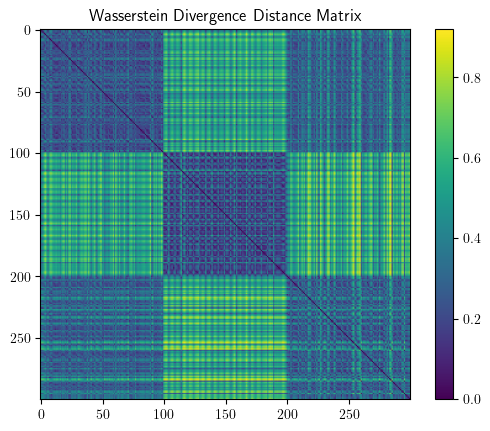

In [89]:
full_metric_matrix = metric_matrix + metric_matrix.T
plt.imshow(full_metric_matrix)
plt.colorbar()
plt.title('Wasserstein Divergence Distance Matrix')
plt.show()

In [90]:
max_dim = 10
num_tests = 5

errors = np.zeros((num_tests,max_dim))

for i in range(max_dim):
    for j in tqdm(range(num_tests),desc=f'Percent Error for {i+1}-d Euclidean Representation'):
        # Create Euclidean Representation Based off Distance Matrix
        embedding = MDS(n_components=i+1, dissimilarity='precomputed')
        X_transformed = embedding.fit_transform(full_metric_matrix)
        
        # Reconstruct Distance Matrix
        D_reconstructed = squareform(pdist(X_transformed))
    
        errors[j,i] = np.linalg.norm((D_reconstructed - full_metric_matrix))
        # percent_errors[j,i] = np.nanmean(abs(D_reconstructed - full_metric_matrix) / full_metric_matrix)

Percent Error for 10-d Euclidean Representation: 100%|███████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


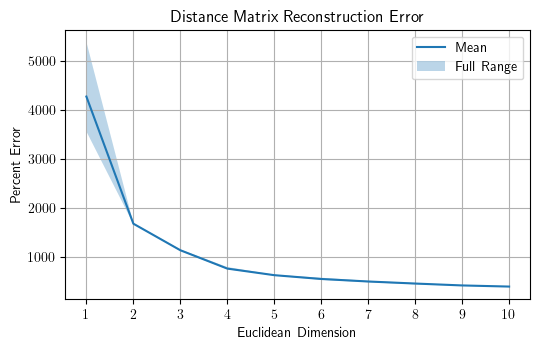

In [286]:
plt.figure(figsize=(6,3.5))
plt.plot(np.arange(1,max_dim+1),errors.mean(axis=0)*100,label='Mean')
plt.fill_between(np.arange(1,max_dim+1),errors.min(axis=0)*100,errors.max(axis=0)*100,alpha=0.3,label='Full Range')
plt.xlabel('Euclidean Dimension')
plt.ylabel('Percent Error')
plt.title('Distance Matrix Reconstruction Error')
# plt.ylim([0,100])
plt.xticks(np.arange(1,max_dim+1,dtype=int))
# plt.yticks(np.arange(0,110,10,dtype=int))
plt.legend()
plt.grid()
plt.show()

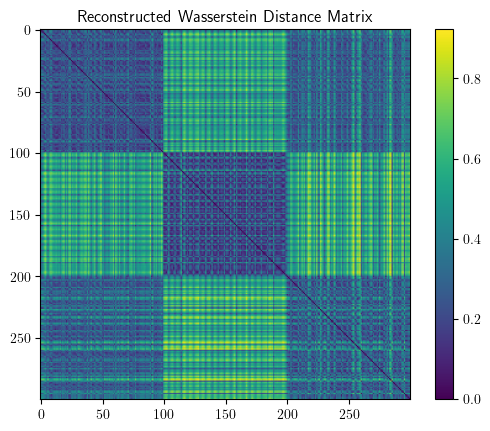

In [92]:
emb_shape = 10

# Create Euclidean Representation Based off Distance Matrix
embedding = MDS(n_components=emb_shape, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(full_metric_matrix)

D_reconstructed = squareform(pdist(X_transformed))

plt.imshow(D_reconstructed)
plt.colorbar()
plt.title('Reconstructed Wasserstein Distance Matrix')
plt.show()

In [93]:
k = 5

centroid, label, inertia = k_means(X_transformed,k)
centroid.shape

(5, 10)

In [105]:
from scipy.spatial.distance import cdist

# Find the 5 closest points in the training data to the cluster centers (surrogate cluster centers)
distances = cdist(centroid,X_transformed)
cluster_indices = np.argmin(distances, axis=1)
cluster_centers = X_transformed[cluster_indices,:]

In [ ]:
for i in range(k):
    for j in range(k+1,k+total_dmd_test_calculations):
        test_metric_matrix[i,j-k] = compute_wasserstein_metric(i,j,df_full,num_observables)

In [131]:
training_metric_matrix = np.zeros((k,total_dmd_calculations))

total_training_metric_calculations = int(k*total_dmd_calculations)

running_sum = 0
for i in range(k):
    c = cluster_indices[i]
    for j in range(total_dmd_calculations):
        training_metric_matrix[i,j] = compute_wasserstein_metric(c,j,df,num_observables)
        
        running_sum += 1

        if np.mod(running_sum,int(total_training_metric_calculations/20)) == 0:
            print(f'{int(running_sum/int(total_training_metric_calculations/100))}%')

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


In [137]:
cluster_indices

array([155, 279, 251, 158,  60], dtype=int64)

In [140]:
for i,c in enumerate(cluster_indices):
    print(training_metric_matrix[i,c])

6.036396552964756e-07
0.0
0.0
0.0
3.980521128227388e-08


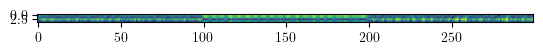

In [141]:
plt.imshow(training_metric_matrix)

In [ ]:
# Reassign labels based on surrogate cluster centers
distances = cdist(cluster_centers,X_transformed)
cluster_indices = np.argmin(distances, axis=1)
cluster_centers = X_transformed[cluster_indices,:]

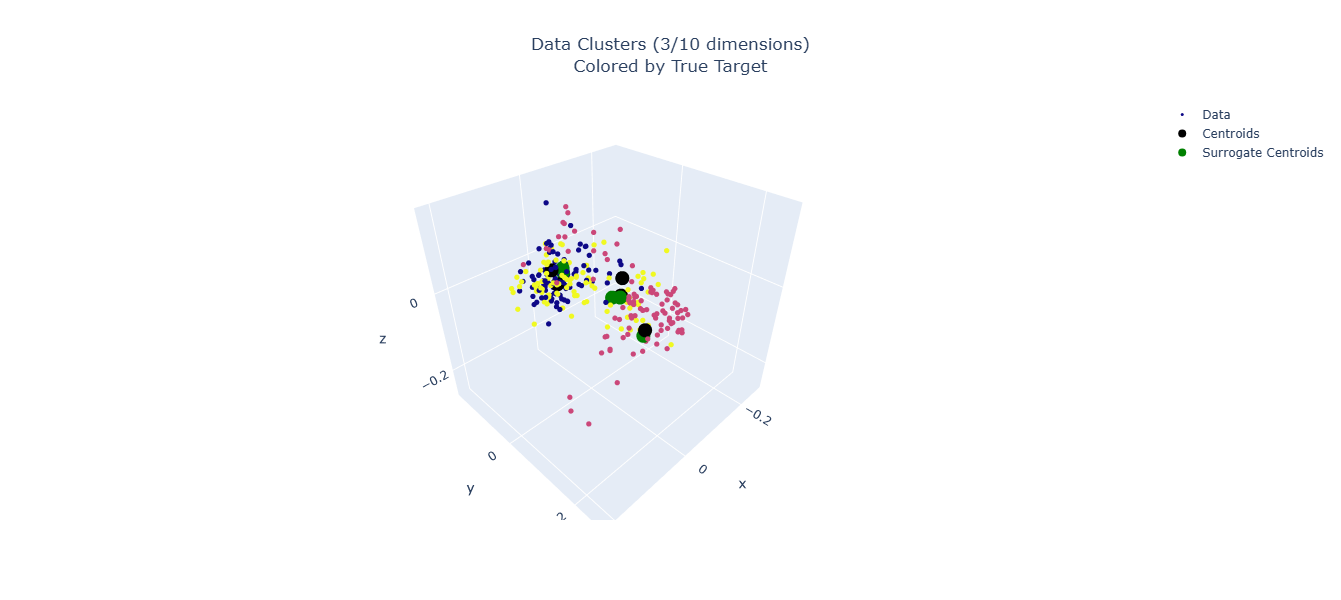

In [95]:
full_data = go.Scatter3d(x=X_transformed[:,0],
                    y=X_transformed[:,1],
                    z=X_transformed[:,2],
                    mode='markers',
                    marker=dict(color=df.target,size=3),
                    name='Data')

centers = go.Scatter3d(x=centroid[:,0],
                       y=centroid[:,1],
                       z=centroid[:,2],
                       mode='markers',
                       marker=dict(color='black',size=8),
                       name='Centroids')

data_centers = go.Scatter3d(x=cluster_centers[:,0],
                            y=cluster_centers[:,1],
                            z=cluster_centers[:,2],
                            mode='markers',
                            marker=dict(color='green',size=8),
                            name='Surrogate Centroids')

data = [full_data,centers,data_centers]

layout=go.Layout(width=900,height=600,
                 title=dict(x=0.5,text=f'Data Clusters (3/{emb_shape} dimensions)<br>Colored by True Target'))

fig = go.Figure(data=data,layout=layout)
fig.show()

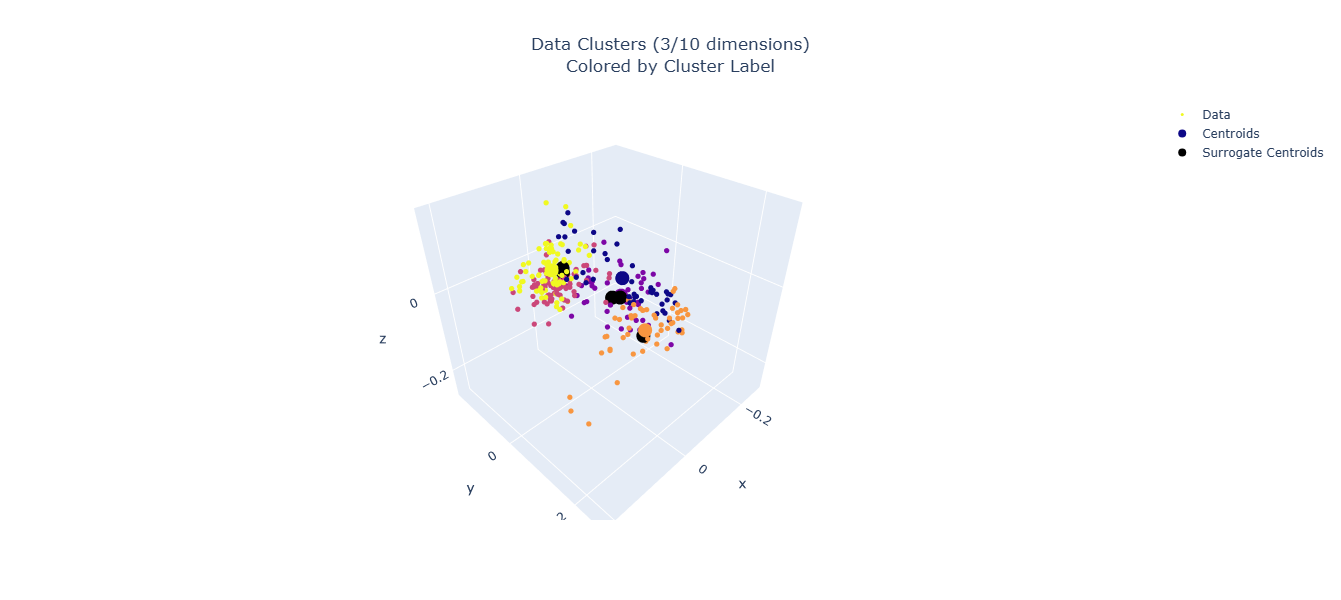

In [96]:
dims = [0,1,2]

full_data = go.Scatter3d(x=X_transformed[:,dims[0]],
                    y=X_transformed[:,dims[1]],
                    z=X_transformed[:,dims[2]],
                    mode='markers',
                    marker=dict(color=label,size=3),
                    name='Data')

centers = go.Scatter3d(x=centroid[:,dims[0]],
                       y=centroid[:,dims[1]],
                       z=centroid[:,dims[2]],
                       mode='markers',
                       marker=dict(color=np.arange(1,k+1),size=8),
                       name='Centroids')


data_centers = go.Scatter3d(x=cluster_centers[:,dims[0]],
                            y=cluster_centers[:,dims[1]],
                            z=cluster_centers[:,dims[2]],
                            mode='markers',
                            marker=dict(color='black',size=8),
                            name='Surrogate Centroids')


data = [full_data,centers,data_centers]

layout=go.Layout(width=900,height=600,title=dict(x=0.5,text=f'Data Clusters (3/{emb_shape} dimensions)<br>Colored by Cluster Label'))

fig = go.Figure(data=data,layout=layout)
fig.show()

In [97]:
df['cluster'] = label

In [98]:
for c in df.target.unique():
    sample = df.loc[df.target.eq(c),'cluster'].value_counts()
    print(c,sample)

0 cluster
4    50
2    42
1     8
Name: count, dtype: int64
1 cluster
3    52
0    42
4     6
Name: count, dtype: int64
2 cluster
1    38
2    33
4    25
0     4
Name: count, dtype: int64


### Classification

In [99]:
# compute_wasserstein_metric(i,j,df,num_observables)

In [101]:
# Create Testing Dataset

n = 1000
m = 4
num_cats = 3
num_test_samples = 10
delay_embeddings = 3
num_observables = m * (delay_embeddings + 1)
n += delay_embeddings
num_segments = 5

if np.mod(n-delay_embeddings,num_segments) != 0:
    raise ValueError(f'Number of segments {num_segments} must divide given data size {n-delay_embeddings}')

segment_length = int(n/num_segments)

cats = [f'c{i}' for i in range(num_cats)]
domain = np.linspace(0,100,n)

test_eigs = []
test_modes = []
test_amps = []

total_dmd_test_calculations = num_cats * num_test_samples * num_segments
print(f'Generating {total_dmd_test_calculations} DMD eigs/modes each with dimensionality {num_observables}')

for cat in cats:

    functions = [get_lambda_source(random_functions[f]) for f in funcs[cat]]
    fs = [re.findall(r'^(f\d+)',functions[i])[0] for i in range(len(functions))]
    print(fs)
        
    for i in tqdm(range(num_test_samples),desc=f'Category {cat} Data Processing & DMD',unit='sample'):
    
        X = create_time_series(domain,
                               random_functions,
                               fs,
                               plot=False)

        if delay_embeddings > 0:
            X = np.hstack([X[i:n-delay_embeddings+i,:] for i in range(delay_embeddings+1)])
        
        
        # DMD by Hand
        for sp in range(num_segments):
            start_ind = sp * segment_length
            end_ind = (sp + 1) * segment_length
            X_split = X[start_ind:end_ind,:]
            
            eigs, modes, b = dmd_by_hand(X_split.T, rank=num_observables)
            test_eigs.append(eigs)
            test_modes.append(modes)
            test_amps.append(b)

if len(all_eigs) != total_dmd_calculations:
    raise ValueError(f'Incorrect Number of DMD Run: expected {total_dmd_calculations}, but ran {len(all_eigs)}')

if all_eigs[0].shape[0] != num_observables:
    raise ValueError(f'Incorrect Observables Count: expected {num_observables}, but got {all_eigs[0].shape[0]}')

Generating 150 DMD eigs/modes each with dimensionality 16
['f10', 'f15', 'f13', 'f15']


Category c0 Data Processing & DMD: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 229.10sample/s]


['f16', 'f6', 'f12', 'f15']


Category c1 Data Processing & DMD: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 256.40sample/s]


['f8', 'f14', 'f4', 'f9']


Category c2 Data Processing & DMD: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 285.78sample/s]


In [102]:
real_eigs = []
imag_eigs = []
full_modes = []

for i in tqdm(range(len(test_eigs))):
    eigs = test_eigs[i]
    modes = test_modes[i]
    
    real_eigs.append(eigs.real)
    imag_eigs.append(eigs.imag)

    norm_modes = [np.linalg.norm(modes[:,k]) / sum(np.linalg.norm(modes,axis=0)) for k in range(num_observables)]
    
    full_modes.append(norm_modes)

real_eigs = np.array(real_eigs)
imag_eigs = np.array(imag_eigs)
full_modes = np.array(full_modes)
target = np.array([i for i in range(num_cats) for _ in range(num_test_samples) for _ in range(num_segments)])[:,np.newaxis]
sample = np.array([j for _ in range(num_cats) for j in range(num_test_samples) for _ in range(num_segments)])[:,np.newaxis]
segment = np.array([k for _ in range(num_cats) for _ in range(num_test_samples) for k in range(num_segments)])[:,np.newaxis]

columns = [f'eig_{i}' for i in range(num_observables)] + [f'real_{i}' for i in range(num_observables)] + [f'imag_{i}' for i in range(num_observables)] + [f'norm_mode_{i}' for i in range(num_observables)] + ['target','sample','segment']
df_test = pd.DataFrame(data=np.hstack([np.array(test_eigs),real_eigs,imag_eigs,full_modes,target,sample,segment]),columns=columns)

for col in df_test.columns:
    if 'eig' not in col:
        df_test[col] = df_test[col].astype(float)
df_test['target'] = df_test['target'].astype(int)
df_test['sample'] = df_test['sample'].astype(int)
df_test['segment'] = df_test['segment'].astype(int)
df_test['cluster'] = -1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 3332.90it/s]


In [106]:
cluster_indices

array([155, 279, 251, 158,  60], dtype=int64)

In [110]:
df_full = pd.concat([df.iloc[cluster_indices],df_test]).reset_index(drop=True)
df_full.shape

(155, 68)

In [113]:
test_metric_matrix = np.zeros((k,total_dmd_test_calculations))

total_test_metric_calculations = int(k * total_dmd_test_calculations)

running_sum = 0
for i in range(k):
    for j in range(k+1,k+total_dmd_test_calculations):
        test_metric_matrix[i,j-k] = compute_wasserstein_metric(i,j,df_full,num_observables)
        
        running_sum += 1

        if np.mod(running_sum,int(total_test_metric_calculations/20)) == 0:
            print(f'{int(running_sum/int(total_test_metric_calculations/100))}%')

5%
10%
15%
21%
26%
31%
37%
42%
47%
52%
58%
63%
68%
74%
79%
84%
89%
95%
100%
105%


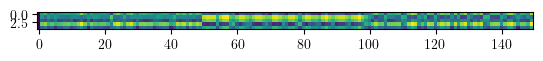

In [114]:
plt.imshow(test_metric_matrix)

In [237]:
training_cluster_assignments = np.argmin(training_metric_matrix,axis=0).reshape(num_cats,num_samples,num_segments)
test_cluster_assignments = np.argmin(test_metric_matrix,axis=0).reshape(num_cats,num_test_samples,num_segments)

In [239]:
N_ks = np.array([(np.sum(training_cluster_assignments == i,axis=2) > 0).ravel().sum() for i in range(k)])
N = num_cats * num_samples

In [243]:
n_train_matrix = np.concatenate([np.sum(training_cluster_assignments == i,axis=2).ravel() for i in range(k)]).reshape(k,num_cats*num_samples).T
c_train_matrix = n_train_matrix / num_segments
inv_c_train_matrix = c_train_matrix * np.log(N / N_ks)

In [244]:
n_test_matrix = np.concatenate([np.sum(test_cluster_assignments == i,axis=2).ravel() for i in range(k)]).reshape(k,num_cats*num_test_samples).T
c_test_matrix = n_test_matrix / num_segments
inv_c_test_matrix = c_test_matrix * np.log(N / N_ks)

In [274]:
train_target = df['target'].values[-num_segments::-num_segments][-1::-1]
test_target = df_test['target'].values[-num_segments::-num_segments][-1::-1]

In [276]:
c_train_matrix.shape, train_target.shape

((60, 5), (60,))

In [277]:
c_test_matrix.shape, test_target.shape

((30, 5), (30,))

In [282]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(c_train_matrix, train_target)

y_pred = svm_model.predict(c_test_matrix)

print(svm_model.score(c_test_matrix,test_target))

1.0
Accuracy: 1.0


In [283]:
cm = confusion_matrix(test_target, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


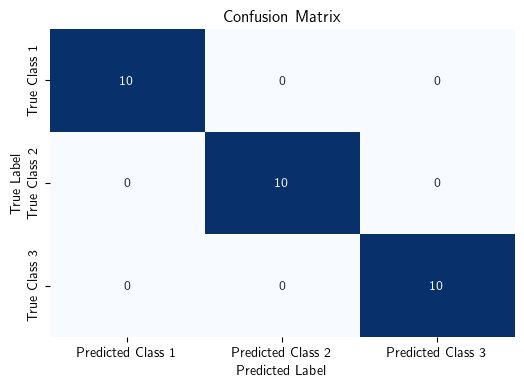

In [285]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'],
            yticklabels=['True Class 1', 'True Class 2', 'True Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()